In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor

from pdpbox import pdp, get_dataset, info_plots

import pycebox.ice as icebox
from pycebox.ice import ice, ice_plot

C:\Users\Acer\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Acer\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\Acer\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
df = pd.read_stata("cattaneo2.dta")

## 1. Exploratory Data Analysis

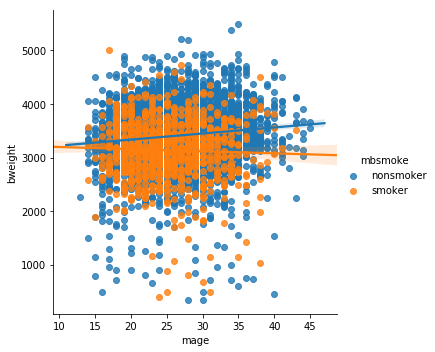

In [3]:
sns.lmplot(x = "mage", y = "bweight", hue = "mbsmoke", data = df)

In [4]:
df.shape

(4642, 23)

In [5]:
df.columns.isna()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [6]:
df.bweight.describe()

count    4642.000000
mean     3361.679879
std       578.819623
min       340.000000
25%      3033.000000
50%      3390.000000
75%      3725.000000
max      5500.000000
Name: bweight, dtype: float64

In [7]:
df.columns

Index(['bweight', 'mmarried', 'mhisp', 'fhisp', 'foreign', 'alcohol',
       'deadkids', 'mage', 'medu', 'fage', 'fedu', 'nprenatal', 'monthslb',
       'order', 'msmoke', 'mbsmoke', 'mrace', 'frace', 'prenatal',
       'birthmonth', 'lbweight', 'fbaby', 'prenatal1'],
      dtype='object')

In [8]:
df.order.value_counts()

1     2033
2     1585
3      835
5      109
6       37
7       23
8        6
10       4
9        4
0        4
11       1
12       1
Name: order, dtype: int64

## 2. Data Preprocessing

In [9]:
df.loc[df['prenatal'] == 2, 'prenatal2'] = 1
df.loc[df['prenatal'] != 2, 'prenatal2'] = 0

df.loc[df['prenatal'] == 3, 'prenatal3'] = 1
df.loc[df['prenatal'] != 3, 'prenatal3'] = 0

df.prenatal2, df.prenatal3 = df.prenatal2.astype(int), df.prenatal3.astype(int)

df.loc[df['order'] == 1, 'order1'] = 1
df.loc[df['order'] != 1, 'order1'] = 0

df.loc[df['order'] == 2, 'order2'] = 1
df.loc[df['order'] != 2, 'order2'] = 0

df.loc[df['order'] == 3, 'order3'] = 1
df.loc[df['order'] != 3, 'order3'] = 0

df.order1, df.order2, df.order3 = df.order1.astype(int), df.order2.astype(int), df.order3.astype(int)

In [10]:
df.mbsmoke.replace({"nonsmoker":0, "smoker":1}, inplace = True)
df.mmarried.replace({"married":1, "notmarried":0}, inplace = True)
df.prenatal1.replace({"Yes":1, "No":0}, inplace = True)
df.msmoke.replace({"0 daily":0, "1-5 daily":1, "6-10 daily":2, "11+ daily":3}, inplace = True)


df.drop(["fbaby", "lbweight", "birthmonth", "monthslb", "prenatal", "order"], axis = 1, inplace = True)

## 3. Loading a pre-trained and tuned xgboost model

In [11]:
X = df.copy()
Y = df.bweight.copy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

X_test.drop(["bweight", "mbsmoke"], axis = 1, inplace = True)

X_treated = X_train[X_train.mbsmoke == 1].copy()
X_treated.drop("mbsmoke", axis = 1, inplace = True)

y_treated = X_treated.bweight
X_treated.drop(["bweight"], axis = 1, inplace = True)

X_untreated = X_train[X_train.mbsmoke == 0].copy()
X_untreated.drop("mbsmoke", axis = 1, inplace = True)

y_untreated = X_untreated.bweight
X_untreated.drop(["bweight"], axis = 1, inplace = True)

In [12]:
dtrain = xgb.DMatrix(X_treated, label=y_treated)
dtest = xgb.DMatrix(X_test, label=y_test)

loaded_model = xgb.Booster()
loaded_model.load_model("my_model.model.treated.real")

preds_treated = loaded_model.predict(dtest)

In [13]:
dtrain = xgb.DMatrix(X_untreated, label=y_untreated)
dtest = xgb.DMatrix(X_test, label=y_test)

loaded_model = xgb.Booster()
loaded_model.load_model("my_model.model.untreated.real")

preds_untreated = loaded_model.predict(dtest)

## 4. CATE estimation

In [14]:
X_test["cate"] = preds_treated - preds_untreated

In [15]:
X_test.cate.describe()

count    929.000000
mean    -255.289505
std      120.289375
min     -532.707031
25%     -335.790771
50%     -269.367920
75%     -194.898926
max      206.318848
Name: cate, dtype: float64

In [16]:
X_test.cate.min()

-532.70703125

In [17]:
X_test[X_test.cate < -450].head()

# to explore variables with the lowest treatment effect

,mmarried,mhisp,fhisp,foreign,alcohol,deadkids,mage,medu,fage,fedu,...,msmoke,mrace,frace,prenatal1,prenatal2,prenatal3,order1,order2,order3,cate
1084,1,0,0,0,0,0,31,12,36,12,...,0,1,1,1,0,0,0,1,0,-504.887451
4618,1,0,0,0,0,1,34,17,36,17,...,0,1,1,1,0,0,0,1,0,-481.520752
3473,0,0,0,0,0,1,36,13,34,12,...,0,0,0,0,0,0,0,0,0,-453.907959
3396,1,0,0,0,0,0,32,17,38,17,...,0,1,1,1,0,0,0,1,0,-452.063477
1315,1,0,0,0,0,0,34,16,36,17,...,0,1,1,1,0,0,0,1,0,-452.063477


## 5. PDP & ICE: PDPbox

In [18]:
X = X_test.copy()
Y = X_test.cate.copy()

X.drop("cate", axis = 1, inplace = True)

In [19]:
regr = RandomForestRegressor(n_estimators = 800,
                             min_samples_split = 2,
                             min_samples_leaf = 1,
                             max_features = 'auto',
                             max_depth=100,
                             bootstrap = 'True',
                             random_state=42)

# parameters after tuning

model = regr.fit(X, Y)

features = list(X.columns)

def __get_quantiles(x):
    return np.greater.outer(x, x).sum(axis=1) / x.size
icebox.__get_quantiles = __get_quantiles

1. Figure 19: PDP of Mother’s Age and the Effect of Smoking with Confidence Interval

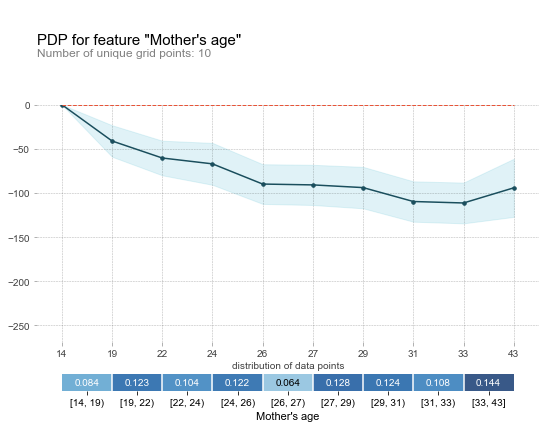

In [20]:
pdp_mage = pdp.pdp_isolate(
    model=model, dataset=X, model_features = features, feature= 'mage')

fig, axes = pdp.pdp_plot(pdp_mage, "Mother's age", frac_to_plot=300, plot_pts_dist=True, x_quantile = True)
fig.set_size_inches(9, 7)

2. Figure 20: ICE Curves of PDP in Figure 19, Centered ICEs

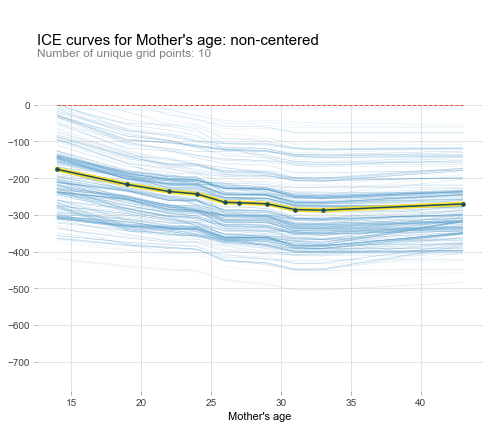

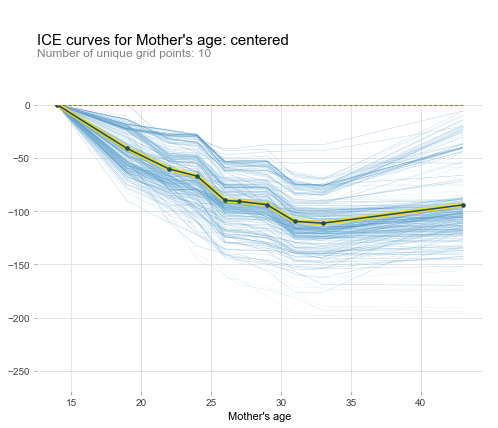

In [21]:
pdp_mage = pdp.pdp_isolate(
    model=model, dataset=X, model_features = features, feature= 'mage')
fig, axes = pdp.pdp_plot(pdp_mage, "Mother's age", plot_lines=True, 
                         frac_to_plot=300, plot_pts_dist=False, x_quantile=False, center = False, plot_params = {'title': "ICE curves for Mother's age: non-centered"})
fig.set_size_inches(8, 7)

pdp_mage = pdp.pdp_isolate(
    model=model, dataset=X, model_features = features, feature= 'mage')
fig, axes = pdp.pdp_plot(pdp_mage, "Mother's age", plot_lines=True, 
                         frac_to_plot=300, plot_pts_dist=False, x_quantile=False, center = True, plot_params = {'title': "ICE curves for Mother's age: centered"})
fig.set_size_inches(8, 7)

3. Figure 22: ICE Curves clustered by the amount of cigarettes mother smoked per day

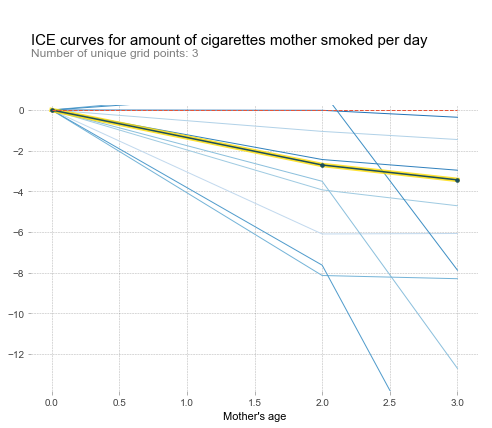

In [22]:
pdp_mage = pdp.pdp_isolate(model=model, dataset=X, model_features = features, feature= 'msmoke')
fig, axes = pdp.pdp_plot(pdp_mage, "Mother's age", plot_lines=True, 
                         frac_to_plot=300, plot_pts_dist=False, x_quantile=False, center = True, plot_params = {'title': "ICE curves for amount of cigarettes mother smoked per day"}, cluster = True, n_cluster_centers = 10)
fig.set_size_inches(8, 7)

## 8. PDP & ICE: Pycebox

In [23]:
gbm = GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
gbm.fit(X, Y)

GradientBoostingRegressor(presort='auto')

In [24]:
ice_df = ice(X, 'mage', gbm.predict)

ice_df.head()

data_mage          14                                                      15  \
mmarried            0                                                       0   
mhisp               0                                            1          0   
fhisp               0                                            1          0   
foreign             0                                            0          0   
alcohol             0                                            0          0   
deadkids            0                                            0          0   
medu               7          8                                 9          8    
fage               0          0                      26         19         15   
fedu               0          0           12         12         10         8    
nprenatal          13         3           14         10         9          9    
msmoke              0          1           0          0          0          0   
mrace               1          1           1          0          0          0   
frace               0          1           1          0          1          0   
prenatal1           0          0           0          0          1          1   
prenatal2           1          0           1          1          0          0   
prenatal3           0          1           0          0          0          0   
order1              1          1           1          1          1          1   
order2              0          0           0          0          0          0   
order3              0          0           0          0          0          0   
mage                                                                            
14        -126.464103  50.055523 -180.244482  49.863365  24.830463  85.229128   
15        -126.464103  50.055523 -180.244482  49.863365  24.830463  85.229128   
16        -126.464103  50.055523 -180.244482  49.863365  24.830463  85.229128   
17        -126.464103  50.055523 -180.244482  49.863365  24.830463  85.229128   
18        -163.902755  24.654263 -202.682102   7.819912  15.843830  36.542327   

data_mage                                                ...          39  \
mmarried                                                 ...           0   
mhisp                                                    ...           0   
fhisp                                                    ...           0   
foreign                                                  ...           0   
alcohol                                                  ...           0   
deadkids                                                 ...           0   
medu              9                                  10  ...          13   
fage              0           18          21         17  ...          0    
fedu              0           13          11         0   ...          12   
nprenatal         8           12          12         10  ...          9    
msmoke             0           0           0          0  ...           1   
mrace              1           1           1          0  ...           1   
frace              0           1           1          0  ...           1   
prenatal1          1           1           1          0  ...           1   
prenatal2          0           0           0          1  ...           0   
prenatal3          0           0           0          0  ...           0   
order1             1           1           1          1  ...           1   
order2             0           0           0          0  ...           0   
order3             0           0           0          0  ...           0   
mage                                                     ...               
14         -1.985346 -148.436127 -148.963969  25.764517  ...  -90.952907   
15         -1.985346 -148.436127 -148.963969  25.764517  ...  -90.952907   
16         -1.985346 -148.436127 -148.963969  25.764517  ...  -90.952907   
17         -1.985346 -148.436127 -148.963969  25.764517  ...  -90.952

4. Figure 21: ICE Curves Colored by Father’s and Mother’s Race

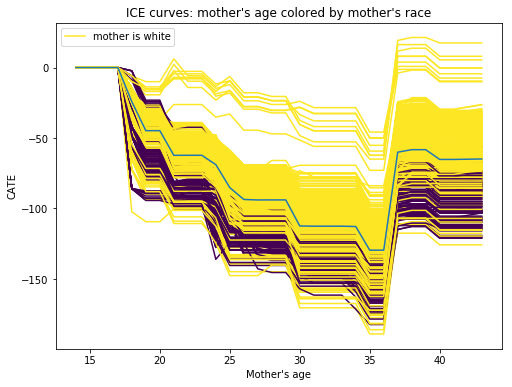

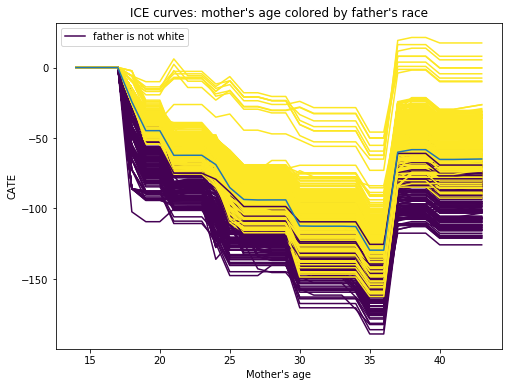

In [25]:
fig, (ice_ax) = plt.subplots(sharex=True, sharey=True, figsize=(8, 6))
ice_plot(ice_df, frac_to_plot=1.0, plot_pdp=True, centered=True, color_by = 'mrace', ax=ice_ax)
ice_ax.set_xlabel("Mother's age");
ice_ax.set_ylabel('CATE');
ice_ax.set_title("ICE curves: mother's age colored by mother's race");
ice_ax.legend(['mother is white'])
fig, (ice_ax) = plt.subplots(sharex=True, sharey=True, figsize=(8, 6))


ice_plot(ice_df, frac_to_plot=1.0, plot_pdp=True, centered=True, color_by = 'frace', ax=ice_ax)
ice_ax.set_xlabel("Mother's age");
ice_ax.set_ylabel('CATE');
ice_ax.set_title("ICE curves: mother's age colored by father's race");
ice_ax.legend(['father is not white'])